In [44]:
import os

import h5py
import numpy as np
from temporaldata import Data

margin_after_stim = 0.01  # seconds
data_slice_duration = 2.5  # seconds
n_average_samples = 32
stimulations = {}

data_parent_folder = "data/ds004080_ccep/sub-ccepAgeUMCU01/"
for session_folder in os.listdir(data_parent_folder):
    data_filename = data_parent_folder + session_folder + "/data.h5"
    print(data_filename)

    # Read from HDF5
    with h5py.File(data_filename, "r") as f:
        user_session = Data.from_hdf5(f)
        electrode_labels = user_session.ieeg_electrodes.labels
        sampling_rate = user_session.ieeg.sampling_rate

        current = user_session.electrical_stimulation.current
        stimulation_site = user_session.electrical_stimulation.stimulation_site
        for stim_i in range(len(stimulation_site)):
            stim_site = stimulation_site[stim_i].decode("utf-8")
            if stim_site not in stimulations:
                stimulations[stim_site] = {}

            stim_current = float(current[stim_i])
            if stim_current not in stimulations[stim_site]:
                stimulations[stim_site][stim_current] = []

            timestamp = user_session.electrical_stimulation.timestamps[stim_i]
            data_slice = (
                user_session.ieeg.slice(
                    timestamp + margin_after_stim,
                    timestamp + data_slice_duration + margin_after_stim,
                ).data.T
                * 1e6
            )  # convert to uV
            electrode_labels_upper = np.char.upper(electrode_labels)
            data_slice[electrode_labels_upper == stim_site.split("-")[0].upper()] *= 0  # remove the electrode that is the stimulation site
            data_slice[electrode_labels_upper == stim_site.split("-")[1].upper()] *= 0  # remove the electrode that is the stimulation site

            if (data_slice.shape[1] % n_average_samples != 0) or (data_slice.shape[1] // n_average_samples != 40):
                continue  # skip if not divisible by n_average_samples

            data_slice = data_slice.reshape(*data_slice.shape[:-1], -1, n_average_samples).mean(axis=-1)  # average inside bins
            sampling_rate_averaged = sampling_rate // n_average_samples
            stimulations[stim_site][stim_current].append(data_slice)

to_del = []
for stim_site in stimulations:
    for current in stimulations[stim_site]:
        if len(stimulations[stim_site][current]) < 10:  # skip if less than 10 trials
            to_del.append((stim_site, current))
        else:
            data_slice = np.array(stimulations[stim_site][current])
            stimulations[stim_site][current] = data_slice
for stim_site, current in to_del:
    del stimulations[stim_site][current]
to_del = []
for stim_site in stimulations:
    if len(list(stimulations[stim_site].keys())) == 0:
        to_del.append(stim_site)
for stim_site in to_del:
    del stimulations[stim_site]

data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-021448/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-041224/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-031422/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-041750/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-061337/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-041550/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-061233/data.h5
data/ds004080_ccep/sub-ccepAgeUMCU01/ses-1_task-SPESclin_run-061343/data.h5


In [45]:
for key in stimulations:
    print(key, list(stimulations[key].keys()))

PT01-PT02 [0.007]
PT03-PT02 [0.007]
PT03-PT04 [0.007]
PT05-PT04 [0.007]
PT05-PT06 [0.007]
PT07-PT06 [0.007]
PT07-PT08 [0.007]
PT09-PT10 [0.007]
PT11-PT10 [0.007]
PT11-PT12 [0.007]
PT13-PT12 [0.007]
PT13-PT14 [0.007]
PT15-PT14 [0.007]
PT15-PT16 [0.007]
PT17-PT18 [0.007]
PT19-PT18 [0.007]
PT19-PT20 [0.007]
PT21-PT20 [0.007]
PT21-PT22 [0.007]
PT23-PT22 [0.007]
PT23-PT24 [0.007]
PT25-PT26 [0.007]
PT27-PT26 [0.007]
PT27-PT28 [0.007]
PT29-PT28 [0.007]
PT29-PT30 [0.007]
PT31-PT30 [0.007]
PT31-PT32 [0.007]
PT33-PT34 [0.007]
PT35-PT34 [0.007]
PT35-PT36 [0.007]
PT37-PT36 [0.007]
PT37-PT38 [0.007]
PT39-PT38 [0.007]
PT39-PT40 [0.007]
PT41-PT42 [0.007]
PT43-PT42 [0.007]
PT43-PT44 [0.007]
PT45-PT44 [0.007]
PT45-PT46 [0.007]
PT47-PT46 [0.007]
PT47-PT48 [0.007]
F49-F50 [0.007]
F51-F50 [0.007]
F51-F52 [0.007]
F53-F52 [0.007]
F53-F54 [0.007]
F55-F54 [0.007]
F55-F56 [0.007]
F57-F58 [0.007]
F59-F58 [0.007]
F59-F60 [0.007]
F61-F60 [0.007]
F61-F62 [0.007]
F63-F62 [0.007]
F63-F64 [0.007]
VT1-VT2 [0.007]
VT3-

In [46]:
chosen_electrode = "vT1"
chosen_electrode_index = list(electrode_labels).index(chosen_electrode)

keys = []
all_responses = []
for key in stimulations:
    if chosen_electrode.upper() in key.upper():
        print(key)
        continue
    for current in stimulations[key]:
        # remove artifacts
        if (stimulations[key][current].mean(axis=0) > 400).any():
            continue
        all_responses.append(stimulations[key][current].mean(axis=0))
        keys.append((key, current))

all_responses = np.array(all_responses)
print(all_responses.shape)

VT1-VT2
(62, 102, 40)


Best alpha: 10.0
Best MSE: 18.91538647667891


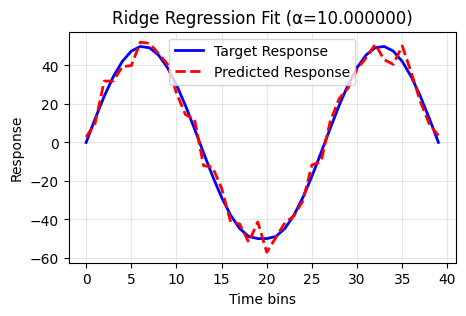

Correlation between target and predicted: 0.9920


In [47]:
chosen_electrode_responses = all_responses[:, chosen_electrode_index, :]

ramp = np.arange(chosen_electrode_responses.shape[1] // 2) / chosen_electrode_responses.shape[1] * 100
chosen_electrode_target_response = np.concatenate([ramp, ramp[::-1]])

chosen_electrode_target_response = np.sin(chosen_electrode_target_response / 10) * 50

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Prepare data for regression - transpose X to match sklearn expectations
X = chosen_electrode_responses.T  # Shape: (n_timebins, n_vars) - transposed
y = chosen_electrode_target_response  # Shape: (n_timebins,)

# Find best alpha using cross-validation or grid search
alphas = np.logspace(1, 20, 50)  # Range of alpha values to test
best_alpha = None
best_score = float("inf")

for alpha in alphas:
    ridge = Ridge(alpha=alpha, positive=True)
    ridge.fit(X, y)
    y_pred = ridge.predict(X)
    mse = mean_squared_error(y, y_pred)

    if mse < best_score:
        best_score = mse
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"Best MSE: {best_score}")

# Train final model with best alpha
best_ridge = Ridge(alpha=best_alpha, positive=True)
best_ridge.fit(X, y)
y_pred_best = best_ridge.predict(X)

import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(5, 3))
plt.plot(chosen_electrode_target_response, "b-", label="Target Response", linewidth=2)
plt.plot(y_pred_best, "r--", label="Predicted Response", linewidth=2)
plt.xlabel("Time bins")
plt.ylabel("Response")
plt.title(f"Ridge Regression Fit (α={best_alpha:.6f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation between target and predicted: {np.corrcoef(chosen_electrode_target_response, y_pred_best)[0, 1]:.4f}")

In [48]:
for key, coef in zip(keys, best_ridge.coef_, strict=False):
    if coef == 0:
        continue
    electrode_pair, stim_amplitude = key
    print(f"Stimulate the pair {electrode_pair} at {stim_amplitude * coef * 1000:.3f} mA")

Stimulate the pair PT03-PT04 at 0.085 mA
Stimulate the pair PT05-PT06 at 0.818 mA
Stimulate the pair PT07-PT06 at 0.533 mA
Stimulate the pair PT09-PT10 at 0.158 mA
Stimulate the pair PT11-PT12 at 0.059 mA
Stimulate the pair PT15-PT14 at 1.795 mA
Stimulate the pair PT19-PT20 at 0.614 mA
Stimulate the pair PT21-PT22 at 0.126 mA
Stimulate the pair PT23-PT22 at 0.638 mA
Stimulate the pair PT25-PT26 at 2.513 mA
Stimulate the pair PT29-PT30 at 0.071 mA
Stimulate the pair PT37-PT36 at 0.263 mA
Stimulate the pair PT37-PT38 at 0.742 mA
Stimulate the pair PT39-PT40 at 0.549 mA
Stimulate the pair PT43-PT44 at 0.019 mA
Stimulate the pair PT47-PT48 at 1.470 mA
Stimulate the pair F51-F52 at 0.250 mA
Stimulate the pair F57-F58 at 0.556 mA
Stimulate the pair F63-F62 at 1.010 mA
Stimulate the pair F63-F64 at 0.347 mA
Stimulate the pair ST3-ST2 at 5.253 mA
Stimulate the pair ST7-ST8 at 0.045 mA
Stimulate the pair OT1-OT2 at 0.333 mA
Stimulate the pair OT5-OT4 at 0.401 mA
Stimulate the pair IH1-IH2 at 1.

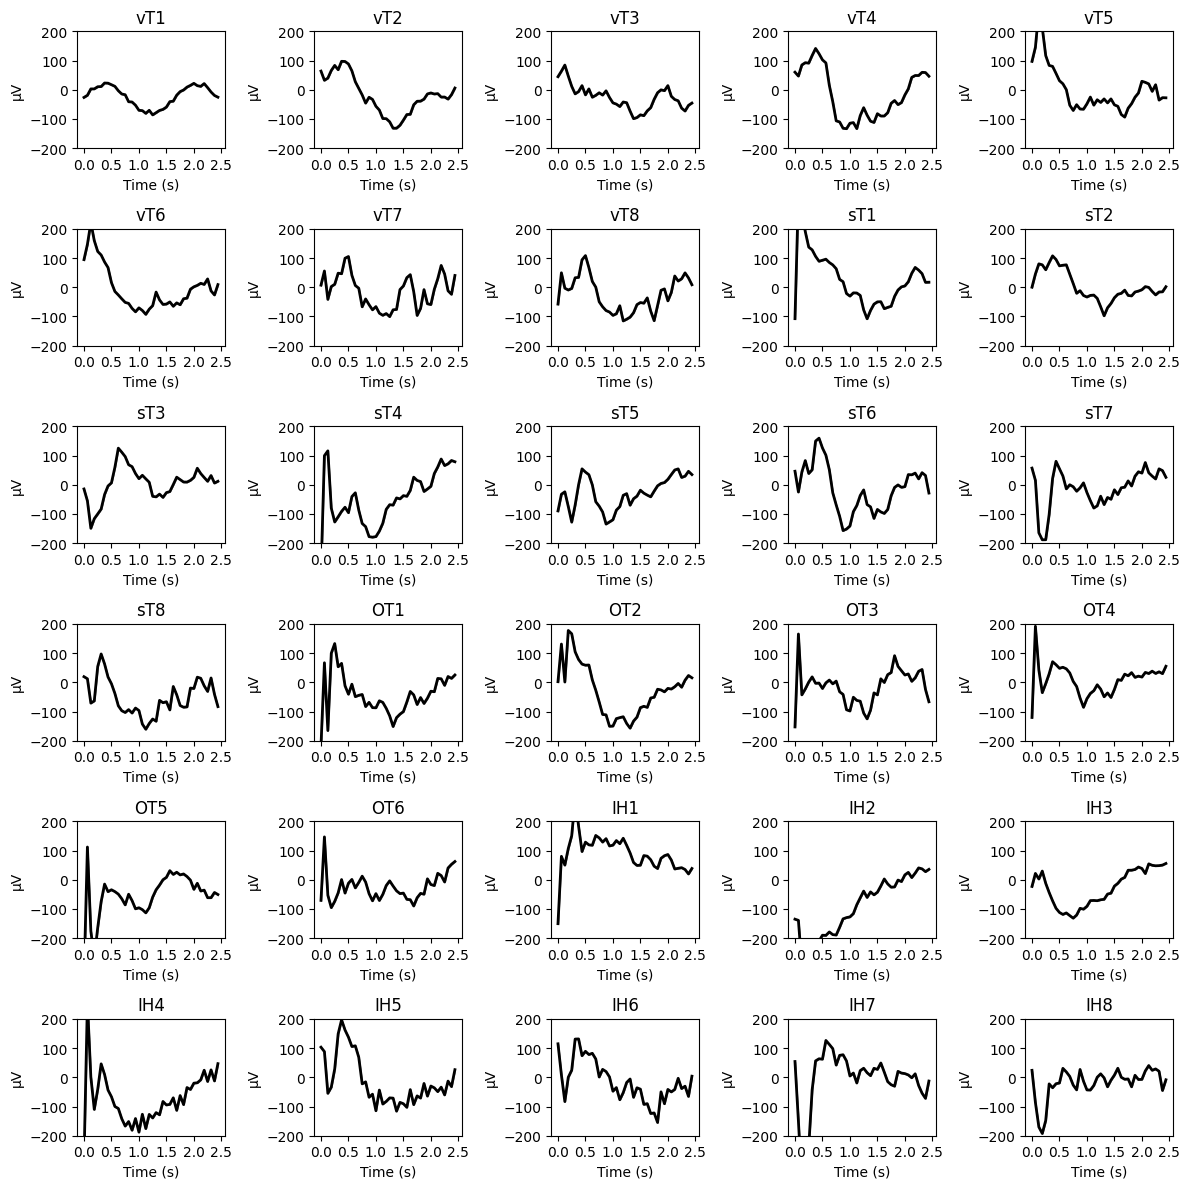

In [49]:
import matplotlib.pyplot as plt

# Calculate mean and SEM across trials (axis 0)
data_slices_averaged = (all_responses * best_ridge.coef_.reshape(-1, 1, 1)).sum(axis=0)  # Shape: (n_timebins, n_electrodes)
mean_voltage = data_slices_averaged
sem_voltage = data_slices_averaged * 0

# Create time axis
n_timesamples = data_slices_averaged.shape[1]
time_axis = np.arange(n_timesamples) / sampling_rate_averaged

# Create subplots for all electrodes
n_electrodes = data_slices_averaged.shape[0]
n_electrodes = 30

n_cols = 5  # Number of columns in subplot grid
n_rows = int(np.ceil(n_electrodes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten() if n_electrodes > 1 else [axes]

for electrode_idx in range(n_electrodes):
    ax = axes[electrode_idx]

    # Plot mean voltage
    ax.plot(time_axis, mean_voltage[electrode_idx], "k-", linewidth=2)

    # Add SEM as shaded region
    ax.fill_between(
        time_axis,
        mean_voltage[electrode_idx] - sem_voltage[electrode_idx],
        mean_voltage[electrode_idx] + sem_voltage[electrode_idx],
        alpha=0.3,
        color="black",
    )

    # Set labels and title
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("µV")
    ax.set_title(f"{electrode_labels[electrode_idx]}")
    ax.set_ylim(-200, 200)
    ax.set_xticks(np.arange(0, 2.6, 0.5))

# Hide unused subplots
for idx in range(n_electrodes, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

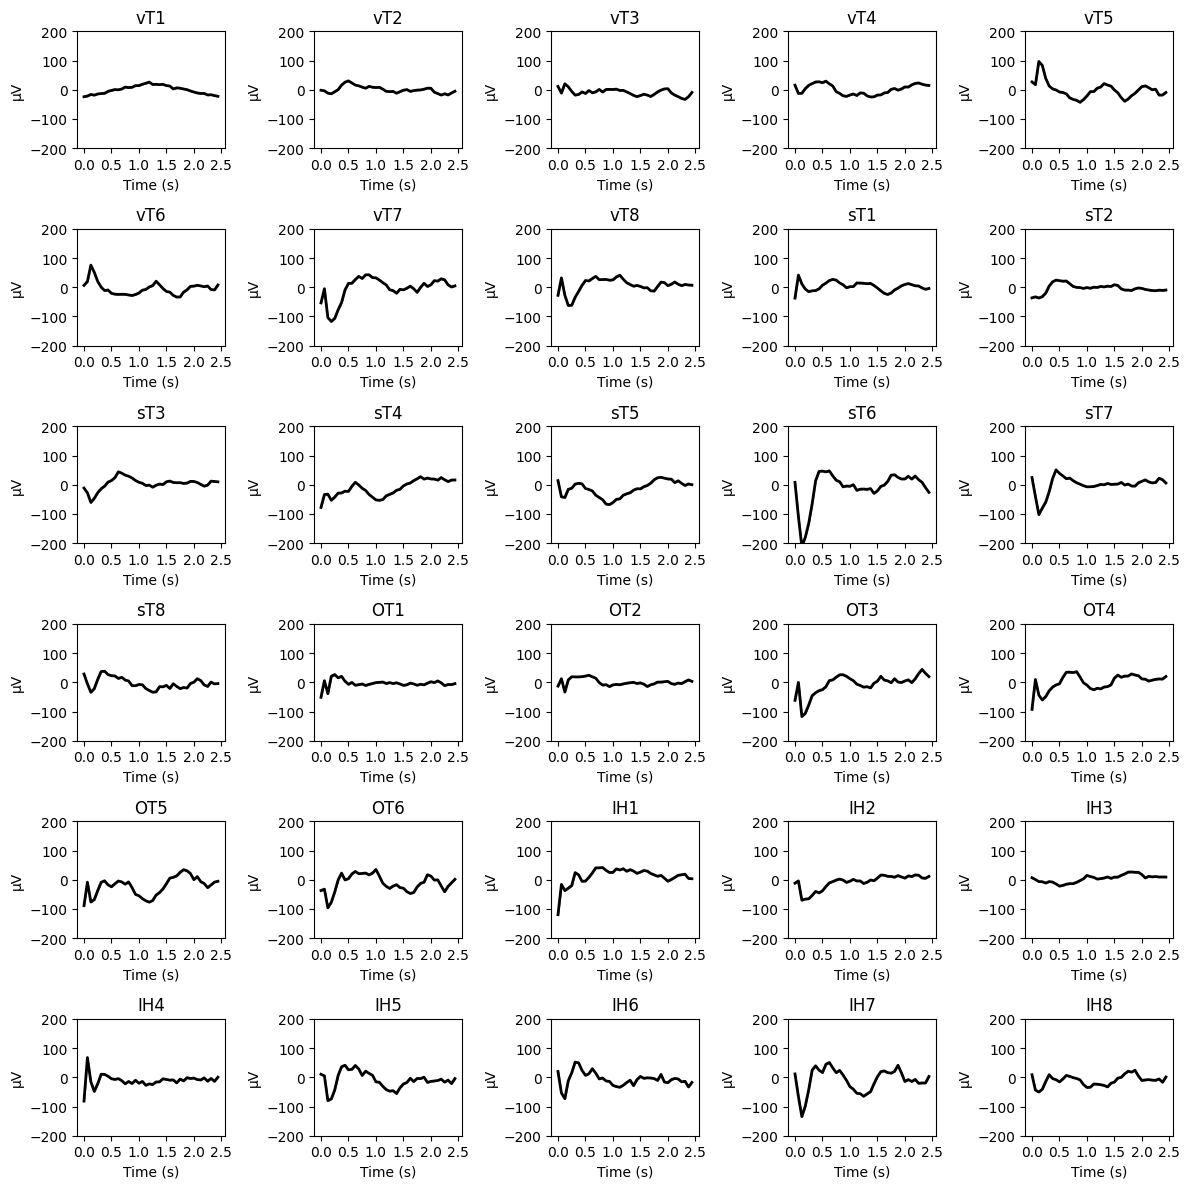

In [ ]:
import matplotlib.pyplot as plt

# Calculate mean and SEM across trials (axis 0)
data_slices_averaged = (all_responses * best_ridge.coef_.reshape(-1, 1, 1)).sum(axis=0)  # Shape: (n_timebins, n_electrodes)
mean_voltage = data_slices_averaged
sem_voltage = data_slices_averaged * 0

# Create time axis
n_timesamples = data_slices_averaged.shape[1]
time_axis = np.arange(n_timesamples) / sampling_rate_averaged

# Create subplots for all electrodes
n_electrodes = data_slices_averaged.shape[0]
n_electrodes = 30

n_cols = 5  # Number of columns in subplot grid
n_rows = int(np.ceil(n_electrodes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten() if n_electrodes > 1 else [axes]

for electrode_idx in range(n_electrodes):
    ax = axes[electrode_idx]

    # Plot mean voltage
    ax.plot(time_axis, mean_voltage[electrode_idx], "k-", linewidth=2)

    # Add SEM as shaded region
    ax.fill_between(
        time_axis,
        mean_voltage[electrode_idx] - sem_voltage[electrode_idx],
        mean_voltage[electrode_idx] + sem_voltage[electrode_idx],
        alpha=0.3,
        color="black",
    )

    # Set labels and title
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("µV")
    ax.set_title(f"{electrode_labels[electrode_idx]}")
    ax.set_ylim(-200, 200)
    ax.set_xticks(np.arange(0, 2.6, 0.5))

# Hide unused subplots
for idx in range(n_electrodes, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
original_all_responses = all_responses.copy()

In [39]:
n_timesteps_walkback = 6
all_responses_arrays = []
for i in range(n_timesteps_walkback):
    all_responses_arrays.append(original_all_responses[:, :, i : original_all_responses.shape[-1] - (n_timesteps_walkback - i)])
all_responses = np.concatenate(all_responses_arrays, axis=0)

In [14]:
all_responses.shape

(372, 102, 34)

Best alpha: 390693.9937054621
Best MSE: 48.080608643496


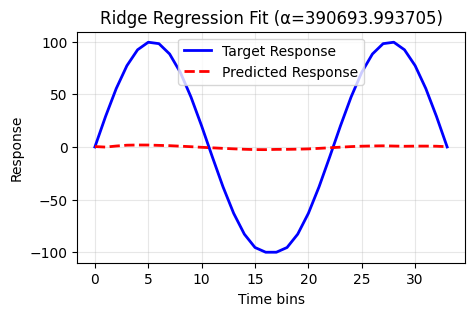

Correlation between target and predicted: 0.9678


In [15]:
chosen_electrode_responses = all_responses[:, chosen_electrode_index, :]

ramp = np.arange(chosen_electrode_responses.shape[1] // 2) / chosen_electrode_responses.shape[1] * 100
chosen_electrode_target_response = np.concatenate([ramp, ramp[::-1]])

chosen_electrode_target_response = np.sin(chosen_electrode_target_response / 10) * 100  # 2000

# Create target for all electrodes - chosen electrode gets the target shape, others get 0
n_electrodes = all_responses.shape[1]
n_timebins = all_responses.shape[2]
full_target = np.zeros((n_electrodes, n_timebins))
full_target[chosen_electrode_index, :] = chosen_electrode_target_response

# Flatten the target to match the flattened electrode responses
y = full_target.flatten()  # Shape: (n_electrodes * n_timebins,)

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Prepare data for regression - reshape to (n_samples, n_features)
# We want each electrode-timebin combination as a separate sample
X = all_responses.transpose(1, 2, 0).reshape(-1, all_responses.shape[0])  # Shape: (n_electrodes * n_timebins, n_trials)

# Find best alpha using cross-validation or grid search
alphas = np.logspace(1, 10, 50)  # Range of alpha values to test
best_alpha = None
best_score = float("inf")

for alpha in alphas:
    ridge = Ridge(alpha=alpha, positive=True)
    ridge.fit(X, y)
    y_pred = ridge.predict(X)
    mse = mean_squared_error(y, y_pred)

    if mse < best_score:
        best_score = mse
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"Best MSE: {best_score}")

# Train final model with best alpha
best_ridge = Ridge(alpha=best_alpha, positive=True)
best_ridge.fit(X, y)
y_pred_best = best_ridge.predict(X)

# Reshape predictions back to electrode x timebin format
y_pred_reshaped = y_pred_best.reshape(n_electrodes, n_timebins)

# Plot results for the chosen electrode
plt.figure(figsize=(5, 3))
plt.plot(chosen_electrode_target_response, "b-", label="Target Response", linewidth=2)
plt.plot(
    y_pred_reshaped[chosen_electrode_index, :],
    "r--",
    label="Predicted Response",
    linewidth=2,
)
plt.xlabel("Time bins")
plt.ylabel("Response")
plt.title(f"Ridge Regression Fit (α={best_alpha:.6f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation between target and predicted: {np.corrcoef(chosen_electrode_target_response, y_pred_reshaped[chosen_electrode_index, :])[0, 1]:.4f}")

In [16]:
sampling_rate

np.int64(2048)

In [ ]:
import matplotlib.pyplot as plt

# Calculate mean and SEM across trials (axis 0)
data_slices_averaged = (all_responses * best_ridge.coef_.reshape(-1, 1, 1)).sum(axis=0)  # Shape: (n_timebins, n_electrodes)
mean_voltage = data_slices_averaged
sem_voltage = data_slices_averaged * 0

# Create time axis
n_timesamples = data_slices_averaged.shape[1]
time_axis = np.arange(n_timesamples) / sampling_rate_averaged

# Create subplots for all electrodes
n_electrodes = data_slices_averaged.shape[0]
n_electrodes = 50

n_cols = 5  # Number of columns in subplot grid
n_rows = int(np.ceil(n_electrodes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten() if n_electrodes > 1 else [axes]

for electrode_idx in range(n_electrodes):
    ax = axes[electrode_idx]

    # Plot mean voltage
    ax.plot(time_axis, mean_voltage[electrode_idx], "k-", linewidth=2)

    # Add SEM as shaded region
    ax.fill_between(
        time_axis,
        mean_voltage[electrode_idx] - sem_voltage[electrode_idx],
        mean_voltage[electrode_idx] + sem_voltage[electrode_idx],
        alpha=0.3,
        color="black",
    )

    # Set labels and title
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("µV")
    ax.set_title(f"{electrode_labels[electrode_idx]}")
    ax.set_ylim(-200, 200)
    ax.set_xticks(np.arange(0, len(time_axis) * n_average_samples / sampling_rate, 0.5))

# Hide unused subplots
for idx in range(n_electrodes, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

: 

: 

Error in callback <function flush_figures at 0x14ec378d05e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

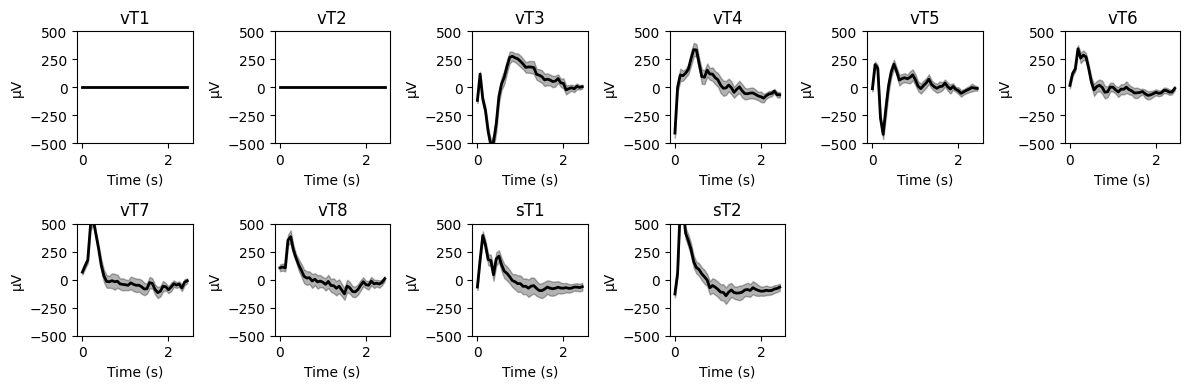

In [ ]:
import matplotlib.pyplot as plt

# Calculate mean and SEM across trials (axis 0)
mean_voltage = np.mean(data_slices_averaged, axis=0)  # Shape: (1280, 102)
sem_voltage = np.std(data_slices_averaged, axis=0) / np.sqrt(data_slices.shape[0])  # Shape: (1280, 102)

# Create time axis
n_timesamples = data_slices_averaged.shape[2]
time_axis = np.arange(n_timesamples) / sampling_rate_averaged

# Create subplots for all electrodes
n_electrodes = data_slices_averaged.shape[1]
n_electrodes = 10

n_cols = 6  # Number of columns in subplot grid
n_rows = int(np.ceil(n_electrodes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten() if n_electrodes > 1 else [axes]

for electrode_idx in range(n_electrodes):
    ax = axes[electrode_idx]

    # Plot mean voltage
    ax.plot(time_axis, mean_voltage[electrode_idx], "k-", linewidth=2)

    # Add SEM as shaded region
    ax.fill_between(
        time_axis,
        mean_voltage[electrode_idx] - sem_voltage[electrode_idx],
        mean_voltage[electrode_idx] + sem_voltage[electrode_idx],
        alpha=0.3,
        color="black",
    )

    # Set labels and title
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("µV")
    ax.set_title(f"{electrode_labels[electrode_idx]}")
    ax.set_ylim(-500, 500)

# Hide unused subplots
for idx in range(n_electrodes, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()